# Final Year Project
## Project 3 - Effectiveness of Skin Cancer Prediction

This notebook contains all of the code developed for project 3, completing tasks similar to data scientists working for a dermatologist to investigate whether some characteristics of skin lesions can be reliably measure with a smartphone app.

The goal is to measure at least 2 of the following characteristics in a set of skin lesion images; asymmetry, border, and color.

Then, we will try to assess how good the measurements are, by predicting the diagnosis of the skin lesions based on these features.

We will focus on the **Melanoma** form of skin cancer.

Group 3:<br>
Crisanna Cornish (ccor@itu.dk)<br>
Danielle Dequin (ddeq@itu.dk)<br>
Gino Franco Fazzi (gifa@itu.dk)<br>
Moneeca Abru Iftikhar Latif (abml@itu.dk)<br>
Carl August Wismer (cwis@itu.dk)

Created: 07-04-2021<br>
Last Modified: 16-04-2021

# Data Sources

Data was provided by the ISIC challenge data sets. <br>
https://challenge.isic-archive.com/data

Codella N, Gutman D, Celebi ME, Helba B, Marchetti MA, Dusza S, Kalloo A, Liopyris K, Mishra N, Kittler H, Halpern A. "Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)". arXiv: 1710.05006 [cs.CV]


## Imports

Libraries used in this notebook.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage.transform import rotate
from skimage import morphology
from skimage import measure
import math

## Constants

Constants to access data on the directory structure of this repository.

In [93]:
TRAIN = './data/training/' 
VALID = './data/validation/'
TEST = './data/test/'

IMG = 'example_image/'
SEG = 'example_segmentation/'
FEAT = 'features/'
TRUTH = 'ground_truth.csv'


## Functions

Functions created for this notebook.

In [37]:
"""FUNCTIONS FOR MASKED IMAGES"""

def get_boundaries(image):
    """Function to locate the boundaries of the lesion over the whole image.
    Takes a segmentation mask image as argument and returns the upper, lower, left and right boundaries."""

    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def get_center(image): # NOT NEEDED ANYMORE ?
    """Function that takes an image as input, and returns the centerpoint of the lesion."""
    up, dw, lt, rt = get_boundaries(image)
    center = ((up+dw)/2, (lt+rt)/2)
    return center
    
def zoom(image):
    """Function to zoom-in (crop) the lesion from blank space. Takes a segmentation mask image as input,
    and returns the rectangle where the lesion is found."""

    up, dw, lt, rt = get_boundaries(image)
    rectangle = image[up:dw+1, lt:rt+1]
    return rectangle

def cuts(image):
    """Function to perform a double cut (vertical and horizontal) of the lesion. Takes a segmentation mask image as input,
    and returns the vertical and horizontal cuts (2 for each dimension). It handles uneven shapes."""

    center_h = image.shape[0] // 2 # The image shape contains a tuple with height and width (in pixels)
    if image.shape[0] % 2 == 0: # If the height is an even number of pixels, the cut returns 2 equal sides
        upside = image[:center_h,:]
        downside = image[center_h:,:]
    else: # If the height is an uneven number of pixels, the cut has to "share" the center, to return 2 equal sides
        upside = image[:center_h,:]
        downside = image[center_h+1:,:]
        
    center_w = image.shape[1] // 2    
    if image.shape[1] % 2 == 0:
        leftside = image[:,:center_w]
        rightside = image[:,center_w:]
    else:
        leftside = image[:,:center_w]
        rightside = image[:,center_w+1:]
 
    return upside, downside, leftside, rightside


def test_symmetry(image, rot_deg=30):
    """Function to test the symmetry of an image. Takes a segmentation mask image and the rotation degree interval and
    returns a symmetry score between zero (non-symmetric) to one (completely symmetric)."""

    assert (rot_deg <= 90) and (rot_deg >= 0), "Rotation degree should be positive and at most 90 deg"
    optimal = 0
    
    for deg in range(0,91, rot_deg):
        rot_image = skimage.transform.rotate(image, deg)
        z = zoom(rot_image)
        
        upside, downside, leftside, rightside = cuts(z)

        up_dw = np.sum(np.bitwise_and(upside.astype(int), np.flipud(downside).astype(int))) /\
        np.sum(np.bitwise_or(upside.astype(int), np.flipud(downside).astype(int)))

        lt_rt = np.sum(np.bitwise_and(leftside.astype(int), np.fliplr(rightside).astype(int))) /\
        np.sum(np.bitwise_or(leftside.astype(int), np.fliplr(rightside).astype(int)))
    
        symmetry = (up_dw+lt_rt)/2
        
        if symmetry > optimal: optimal = symmetry

    return symmetry
    
def rgb2gray(rgb):
    """Function to convert a RGB image to grayscale."""
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def crop(image, mask, resize=True, warning=True):
    if image.shape[:2] != mask.shape[:2]:
        if warning:
            print("Image and Mask must have the same size. OPERATION CANCELLED.")
        else: return
    else:
        img = image.copy()
        img[mask==0] = 0

        if resize:
            u,d,l,r = get_boundaries(mask)
            img = img[u:d,l:r,...]
        return img

def color_std(image):
    """A function that takes an image as input, computes and returns the average standard deviation of all the
    rgb color values."""
    try:
        R = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,0]
        G = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,1]
        B = image[np.where(image[:,:,0] != 0) and np.where(image[:,:,1] != 0) and np.where(image[:,:,2] != 0)][:,2]
        color_std = (np.std(R) + np.std(G) + np.std(B)) /3
    except:
        color_std = 'NA'
    return color_std

def check_border(image, border=0.01, tolerance=0.2, warning=True):
    """Function to check if the lesion might be exceeding the image. Take the following arguments:
    - image: segmentation mask image to check.
    - border: the percentage of pixels to consider as a border. 10% by default.
    - tolerance: the percentage of tolerance for a lesion to be at the border of the image. 20% by default.
    - warning: boolean to indicate if a textual warning should be issue when checking the border. True by default."""
    h = int(image.shape[0] * border)
    w = int(image.shape[1] * border)
    up = (np.sum(image[h,:]) / image.shape[1]) > tolerance
    dw = (np.sum(image[-h,:]) / image.shape[1]) > tolerance
    lt = (np.sum(image[:,w]) / image.shape[0]) > tolerance
    rt = (np.sum(image[:,w]) / image.shape[0]) > tolerance
    if warning:
        if up or dw or lt or rt: return "This lesion might be overflowing the image"
        else: return "This lesion does not seem to be overflowing the image"
    else:
        return up or dw or lt or rt
    
"""
#def laydown(image): # I THINK WE MAY NOT NEED THIS
#    z = zoom(image)
#    u, d, l, r = get_boundaries(z)
#    if (d-u) >= (r-l):
#        return skimage.transform.rotate(image, 90) 
#    else: return image
        
def reverse(image):
    new = image.copy()
    new[np.where(image == 1)], new[np.where(image == 0)] = 0, 1
    return new
"""

def masker(image, sens):
    '''Takes image, converts to a grayscale image, and returns a masked 
    image that only shows values below the sensitivity given as input.'''
    
    gray = rgb2gray(image) # Create grayscale image
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    # use plt.imshow(masker(image,sens), cmap='gray') to see image
    
    return img2.astype(int)

def dimensions(mask1):
    '''calculates height(max) and width(90 deg to height)
        returns height, width, rotated mask image, degree of rotation'''
    pixels_in_col = np.max(np.sum(mask1, axis=0))

    rot = 0
    max_col = 0
    rot_max = 0
    for _ in range(9):
        rot_im = transform.rotate(mask1,rot)
        pixels_in_col = np.max(np.sum(rot_im, axis=0))
        if pixels_in_col > max_col:
            max_col = pixels_in_col
            rot_max = rot
            pixels_in_row = np.max(np.sum(rot_im, axis=1))
        rot += 10

    return max_col, pixels_in_row, rot_max

def measure_area_perimeter(mask, option=1):
    """A function that takes either a segmented image or perimeter 
    image as input, and calculates the length of the perimeter of a lesion."""
    
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    if option == 1:
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded

        # Now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)
    else:
        perimeter = measure.perimeter(mask)
        

    return area, perimeter

def predict(bi_image): # Predict might be a little confusing ?
    
    area = np.sum(bi_image)
    _, peri = perimeter(bi_image)
    
    area_from_peri = pi*((peri/(2*pi))**2)
    peri_from_area = 2*pi*sqrt(area/pi)
    
    return area, area_from_peri, peri, peri_from_area  

## Exploratory Data Analysis

(NOTE) Here we could show how we visualize a couple of images and masks to get familiar with the images and its attributes.

(382, 634)


672.4232298188397

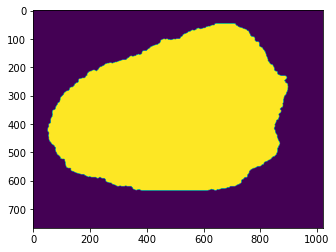

## Dataset Creation

(NOTE) We load and access the metadata included in our source data.

In [90]:
df = {} # A main dictionary will hold our different labels datasets

df['train'] = {'path': TRAIN, 'label': pd.read_csv(TRAIN + TRUTH, index_col='image_id')}
df['validation'] = {'path': VALID, 'label': pd.read_csv(VALID + TRUTH, index_col='image_id')}
df['test'] = {'path': TEST, 'label': pd.read_csv(TEST + TRUTH, index_col='image_id')}


## Dataset Manipulation

#### Figure compression

In order to work more efficiently, we decide to crop the images to reduce their dimensions to the part of the image that contains the lesion. For this, we will use our segmented masks, as following: the color images will be croped to the rectangle where the lesion is, and saving the new image with reduced dimensions. This process must be done only once.

In [81]:
WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

print("\n----- PLEASE BE PATIENT -----\n")

if WARN.lower().startswith("y"):
    i = 1
    for k, v in df.items():
        for img_id in v['label'].index:
            imgpath = v['path'] + IMG + img_id + '.jpg'
            mskpath = v['path'] + SEG + img_id + '_segmentation.png'
            img = plt.imread(imgpath)
            msk = plt.imread(mskpath)
            new = crop(img, msk, warning=False)
            if new is None:
                pass
            else: plt.imsave(imgpath, new)
            print(f'\rResizing image # {i}', end='\r')
            i += 1
            
else: print("OPERATION CANCELLED")

This operation may take several minutes. Do you wish to continue: (Yes/No) N

----- PLEASE BE PATIENT -----

OPERATION CANCELLED


## Feature Extraction

(NOTE) We proceed to extract features of interest for our predictive model

#### Asymmetry

To test for asymmetry we run a function to calculate a score based on how similar an image is when cut horizontally and vertically. We assign a score between 0 (non asymmetric) and 1 (totally asymmetric) for both cuts, and we take the average to convey a unique value.

In [99]:
DATASET = input("Which dataset to calculate? [train, validation, test] ")
if DATASET.lower() not in ['train', 'validation', 'test']:
    print('OPERATION CANCELLED')
else:
    data = df[DATASET]['label']

    DoBatch = int(input("How many batches? "))
    if DoBatch > data.shape[0]:
        DoBatch = data.shape[0]
    batch = int(input("Do batch # "))
    assert batch <= DoBatch, "Wrong Batch #"

    WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

    REWRITE = input("Do you wish to overwrite the /symmetry.csv file?: (Yes/No) ")
    print("\n----- PLEASE BE PATIENT -----\n")


    length = data.shape[0] // DoBatch
    start = length * (batch - 1)
    end = length * (batch)

    if WARN.lower().startswith("y"):
        symmetry = {}
        i = 1
        for ix, row in data[start:end].iterrows():
            file_path = df[DATASET]['path'] + SEG + str(ix) + "_segmentation.png"
            image = plt.imread(file_path)

            ptg = round((i / length) * 100,2)
            print(f'\rCalculating symmetry: {ptg}%', end='\r')
            symmetry[ix] = test_symmetry(image)
            i += 1
    else: print("OPERATION CANCELLED")

    if REWRITE.lower().startswith("y"):
        with open(df[DATASET]['path'] + FEAT + f'symmetry_{str(batch)}.csv', 'w') as outfile:
            outfile.write('image_id'+','+'symmetry'+'\n')
            for k, v in symmetry.items():
                line = k +','+str(v)
                outfile.write(line+'\n')

Which dataset to calculate? [train, validation, test] validation
How many batches? 75
Do batch # 75
This operation may take several minutes. Do you wish to continue: (Yes/No) y
Do you wish to overwrite the /symmetry.csv file?: (Yes/No) y

----- PLEASE BE PATIENT -----



#### Border (Compactness method)

In [ ]:
DATASET = input("Which dataset to calculate? [train, validation, test] ")
if DATASET.lower() not in ['train', 'validation', 'test']:
    print('OPERATION CANCELLED')
else:
    data = df[DATASET]['label']

    DoBatch = int(input("How many batches? "))
    if DoBatch > data.shape[0]:
        DoBatch = data.shape[0]
    batch = int(input("Do batch # "))
    assert batch <= DoBatch, "Wrong Batch #"

    WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

    REWRITE = input("Do you wish to overwrite the /compactness.csv file?: (Yes/No) ")
    print("\n----- PLEASE BE PATIENT -----\n")


    length = data.shape[0] // DoBatch
    start = length * (batch - 1)
    end = length * (batch)

if WARN.lower().startswith("y"):
    compactness = {}
    i = 1
    for ix, row in labels.iterrows():
        file_path = SEG_PATH + str(ix) + "_segmentation.png"
        image = plt.imread(file_path)
        
        ptg = round(i / len(labels.index)*100,2)
        print(f'\rCalculating compactness: {ptg:.2%}', end='\r')
        area, per = measure_area_perimeter(image, option=2)
        compactness[ix] = (4* math.pi * area) / (per**2)
        i += 1
else: print("OPERATION CANCELLED")
    
    if REWRITE.lower().startswith("y"):
        with open(df[DATASET]['path'] + FEAT + f'compactness_{str(batch)}.csv', 'w') as outfile:
            outfile.write('image_id'+','+'compactness'+'\n')
            for k, v in symmetry.items():
                line = k +','+str(v)
                outfile.write(line+'\n')

#### Color

(NOTE) Should we do a color analysis or focus on shape features?

#### Eccentricity

(NOTE) Maybe? NEEDS TO USE A CORRECT MAJOR AXIS AND MINOR AXIS.

In [ ]:
WARN = input("This operation may take several minutes. Do you wish to continue: (Yes/No) ")

REWRITE = input("Do you wish to overwrite the /features/eccentricity.csv file?: (Yes/No) ")
print("\n----- PLEASE BE PATIENT -----\n")

if WARN.lower().startswith("y"):
    eccentricity = {}
    i = 1
    for ix, row in df[:10].iterrows():
        file_path = SEG_PATH + str(ix) + "_segmentation.png"
        image = plt.imread(file_path)
        
        ptg = round(i / len(df.index)*100,2)
        print(f'\rCalculating eccentricity: {ptg}%', end='\r')
        up, dw, lt, rt = get_boundaries(image)
        h, w = dw-up, rt-lt
        short = min(h, w)
        long = max(h, w)
        eccentricity[ix] = short/long
        i += 1
else: print("OPERATION CANCELLED")
    
if REWRITE.lower().startswith("y"):
    with open(FEAT_PATH + 'eccentricity.csv', 'w') as outfile:
        outfile.write('image_id'+','+'eccentricity'+'\n')
        for k, v in compactness.items():
            line = k +','+str(v)
            outfile.write(line+'\n')

### Aggregating features to datasets

We will now add the recently extracted features to our main dataset

In [ ]:
df

<AxesSubplot:xlabel='label', ylabel='symmetry'>

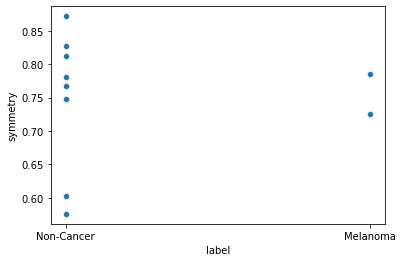

In [11]:


feat_symmetry = pd.read_csv(FEAT_PATH + 'symmetry.csv', index_col='image_id') 
feat_compactness = pd.read_csv(FEAT_PATH + 'compactness.csv', index_col='image_id')
df = labels.merge(feat_symmetry, how = 'inner', on = 'image_id').merge(feat_compactness, how = 'inner', on = 'image_id')

# Transform binary columns into labels
label = []
for ix, row in df.iterrows():
    if row['melanoma'] == 1:
        label.append('Melanoma')
    elif row['seborrheic_keratosis'] == 1:
        label.append('Keratosis')
    else:
        label.append('Non-Cancer')
df['label'] = label
df.drop('melanoma', axis=1, inplace=True)
df.drop('seborrheic_keratosis', axis=1, inplace=True)
df

### Analysis of Features

### Model

#### Creation

#### Data splitting

#### Feature scalling

#### Model fitting

#### Model prediction

#### Model score